In [1]:
%pip install segment-geospatial

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [2]:
import os
import leafmap
from samgeo import SamGeo, show_image, download_file, overlay_images, tms_to_geotiff
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
# from colorthief import ColorThief
import requests

In [12]:
m = leafmap.Map(center=[31.87629254498972, 74.0318694136626], zoom=17, height="800px") # [37.8713, -122.2580]
m.add_basemap("SATELLITE")
m

Map(center=[31.87629254498972, 74.0318694136626], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [13]:
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    bbox = [-122.2659, 37.8682, -122.2521, 37.8741]

In [14]:
m.user_roi_bounds()

[74.0286, 31.8763, 74.0358, 31.8794]

# **Download the Image**

In [15]:
image = "satellite.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/8
Downloaded image 2/8
Downloaded image 3/8
Downloaded image 4/8
Downloaded image 5/8
Downloaded image 6/8
Downloaded image 7/8
Downloaded image 8/8
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


In [16]:
# image = '/path/to/your/own/image.tif'

In [17]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=13640219.0, center=[31.877850000000002, 74.03219999999999], controls=(ZoomControl(options=['positio…

In [18]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=None,
)

In [19]:
sam.generate(image, output="masks.tif", foreground=True, unique=True)

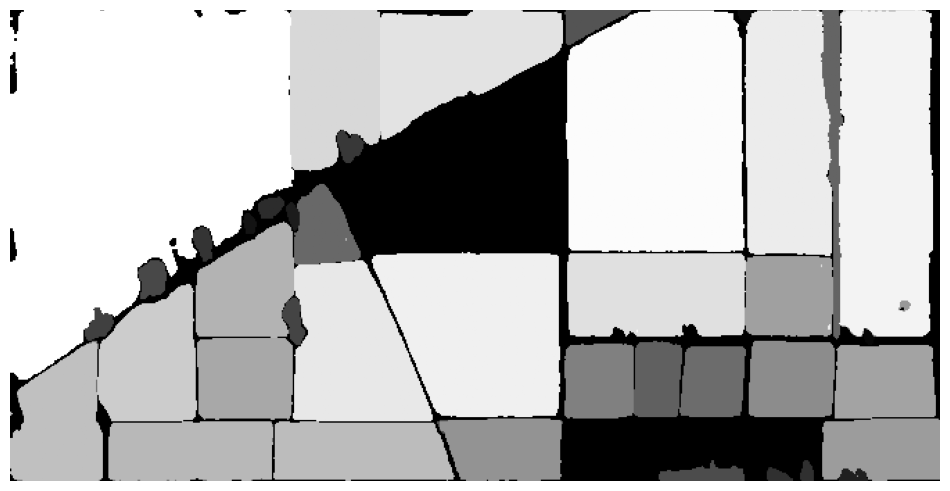

In [20]:
sam.show_masks(cmap="binary_r")

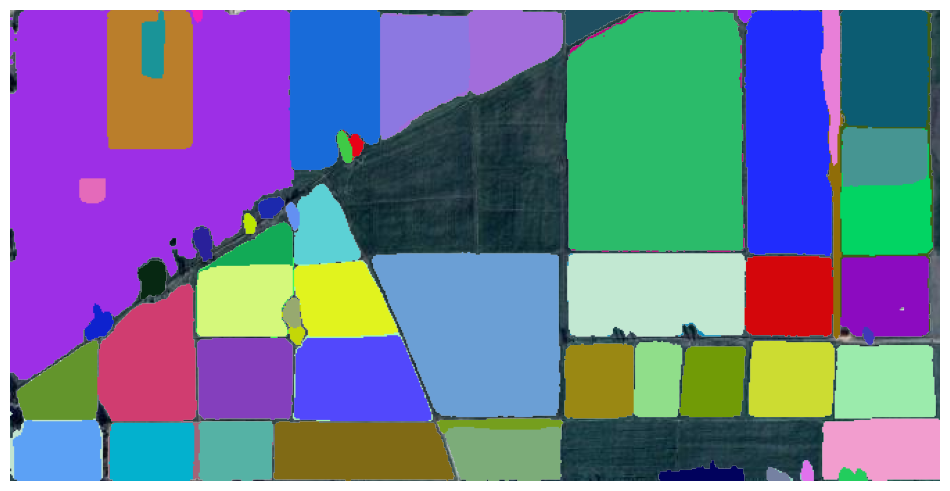

In [21]:
sam.show_anns(axis="off", alpha=1, output="annotations.tif")


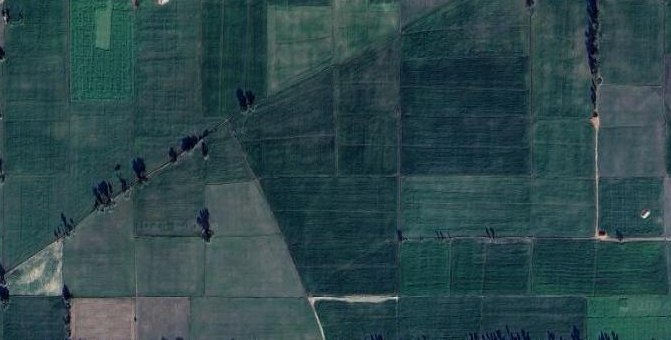
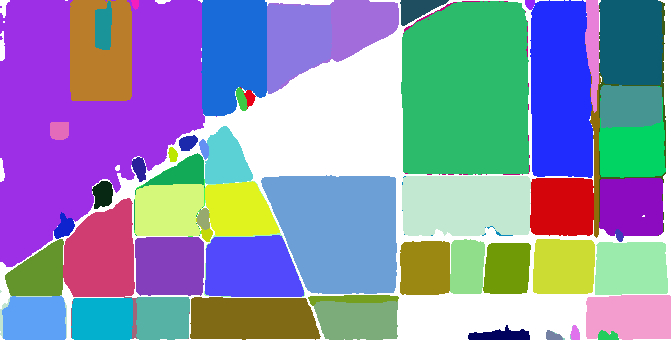

In [22]:
leafmap.image_comparison(
    "satellite.tif",
    "annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

In [23]:
m.add_raster("annotations.tif", alpha=0.5, layer_name="Masks")
m

Map(bottom=6820224.0, center=[31.877850000000002, 74.03219999999999], controls=(ZoomControl(options=['position…

In [24]:
sam.tiff_to_vector("masks.tif", "masks.gpkg")

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [25]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [26]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

In [27]:
sam.generate(image, output="masks2.tif", foreground=True)

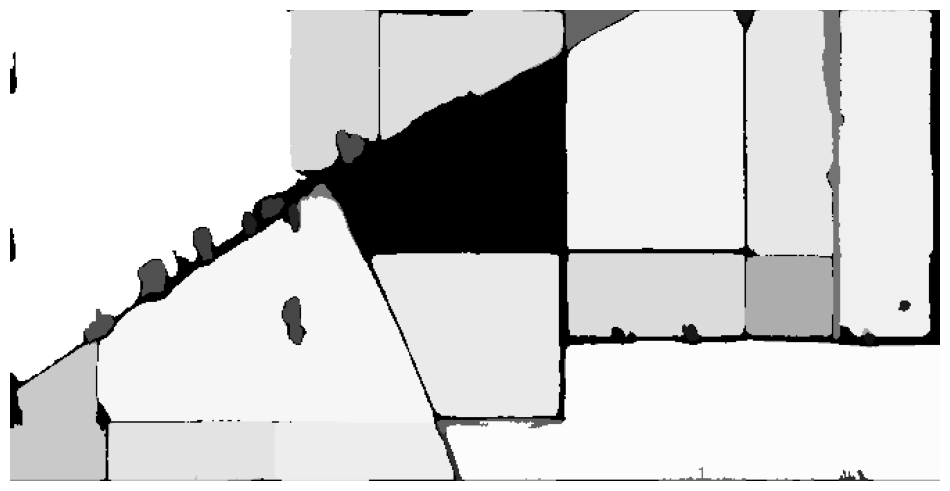

In [28]:
sam.show_masks(cmap="binary_r")

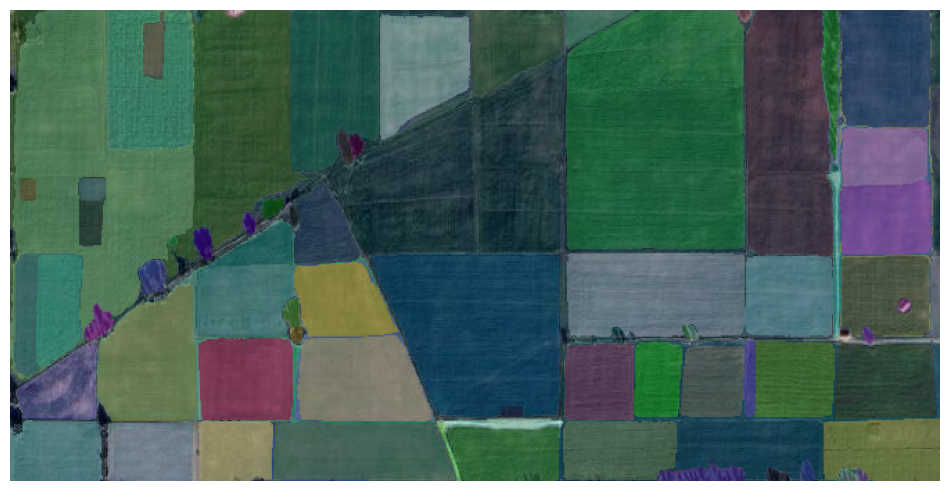

In [29]:
sam.show_anns(axis="off", opacity=1, output="annotations2.tif")


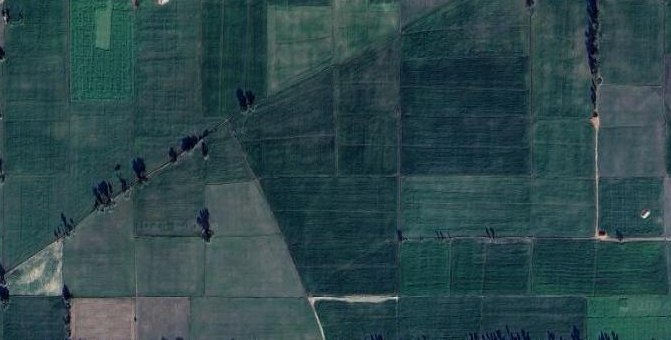
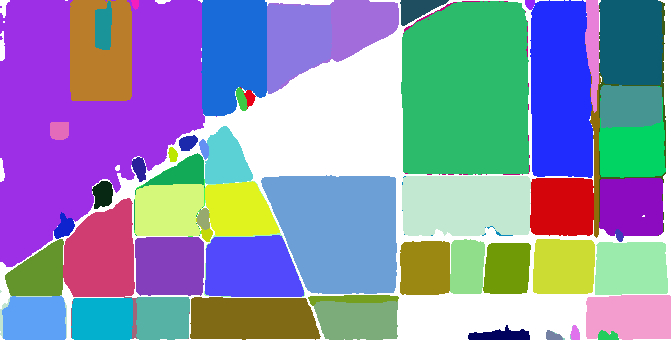

In [30]:
leafmap.image_comparison(
    image,
    "annotations.tif",
    label1="Image",
    label2="Image Segmentation",
)

In [31]:
overlay_images(image, "annotations2.tif", backend="TkAgg")

The TkAgg backend is not supported in Google Colab. The overlay_images function will not work on Colab.


In [32]:
import rasterio
from scipy.ndimage import label
from skimage.measure import regionprops

def extract_segmented_regions(file_path):
    with rasterio.open(file_path) as dataset:
        # Read the image data as a numpy array (assume single channel)
        image_data = dataset.read(1)

        # Label the connected components (segmented regions)
        labeled_array, num_features = label(image_data)

        # Extract bounding boxes for each labeled region
        regions = regionprops(labeled_array)

        # Create a list to store region bounding boxes with coordinates
        segmented_regions = []

        for region in regions:
            # Get the bounding box coordinates of the region
            min_row, min_col, max_row, max_col = region.bbox
            coordinates = {
                "region_id": region.label,
                "bounding_box": {
                    "top_left": rasterio.transform.xy(dataset.transform, min_row, min_col),
                    "bottom_right": rasterio.transform.xy(dataset.transform, max_row, max_col)
                }
            }
            segmented_regions.append(coordinates)

    return segmented_regions

# Define the file path and extract the segmented regions
file_path = 'masks.tif'
segmented_regions = extract_segmented_regions(file_path)

# Show the number of detected regions and their bounding box coordinates
print(f"Number of segmented regions: {len(segmented_regions)}")
for region in segmented_regions:
    print(region)


Number of segmented regions: 19
{'region_id': 1, 'bounding_box': {'top_left': (8240826.653382101, 3747489.795427528), 'bottom_right': (8241303.253431506, 3747170.665464214)}}
{'region_id': 2, 'bounding_box': {'top_left': (8241304.447917845, 3747489.795427528), 'bottom_right': (8241362.977748474, 3747458.719101513)}}
{'region_id': 3, 'bounding_box': {'top_left': (8241306.836890524, 3747489.795427528), 'bottom_right': (8241622.181284116, 3747200.546546921)}}
{'region_id': 4, 'bounding_box': {'top_left': (8241305.642404185, 3747488.60018422), 'bottom_right': (8241459.731141962, 3747280.6278485768)}}
{'region_id': 5, 'bounding_box': {'top_left': (8240826.653382101, 3747482.6239676783), 'bottom_right': (8240829.04235478, 3747480.2334810616)}}
{'region_id': 6, 'bounding_box': {'top_left': (8240826.653382101, 3747446.7666684296), 'bottom_right': (8240830.23684112, 3747441.9856951963)}}
{'region_id': 7, 'bounding_box': {'top_left': (8240986.7145515755, 3747339.194770683), 'bottom_right': (8241

In [33]:
import rasterio
from scipy.ndimage import label
from skimage.measure import regionprops

def extract_segmented_bounding_boxes(file_path):
    with rasterio.open(file_path) as dataset:
        # Read the image data as a numpy array (assume single channel)
        image_data = dataset.read(1)

        # Label the connected components (segmented regions)
        labeled_array, num_features = label(image_data)

        # Extract bounding boxes for each labeled region
        regions = regionprops(labeled_array)

        # Create a list to store region bounding boxes with coordinates
        bounding_boxes = []

        for region in regions:
            # Get the bounding box coordinates of the region
            min_row, min_col, max_row, max_col = region.bbox
            coordinates = {
                "region_id": region.label,
                "bounding_box": {
                    "top_left": rasterio.transform.xy(dataset.transform, min_row, min_col),
                    "top_right": rasterio.transform.xy(dataset.transform, min_row, max_col),
                    "bottom_left": rasterio.transform.xy(dataset.transform, max_row, min_col),
                    "bottom_right": rasterio.transform.xy(dataset.transform, max_row, max_col)
                }
            }
            bounding_boxes.append(coordinates)

    return bounding_boxes

# Example usage
file_path = 'masks.tif'
bounding_boxes = extract_segmented_bounding_boxes(file_path)

# Print the number of bounding boxes and sample coordinates
print(f"Number of bounding boxes: {len(bounding_boxes)}")
for box in bounding_boxes[:len(bounding_boxes)]:
    print(box)


Number of bounding boxes: 19
{'region_id': 1, 'bounding_box': {'top_left': (8240826.653382101, 3747489.795427528), 'top_right': (8241303.253431506, 3747489.795427528), 'bottom_left': (8240826.653382101, 3747170.665464214), 'bottom_right': (8241303.253431506, 3747170.665464214)}}
{'region_id': 2, 'bounding_box': {'top_left': (8241304.447917845, 3747489.795427528), 'top_right': (8241362.977748474, 3747489.795427528), 'bottom_left': (8241304.447917845, 3747458.719101513), 'bottom_right': (8241362.977748474, 3747458.719101513)}}
{'region_id': 3, 'bounding_box': {'top_left': (8241306.836890524, 3747489.795427528), 'top_right': (8241622.181284116, 3747489.795427528), 'bottom_left': (8241306.836890524, 3747200.546546921), 'bottom_right': (8241622.181284116, 3747200.546546921)}}
{'region_id': 4, 'bounding_box': {'top_left': (8241305.642404185, 3747488.60018422), 'top_right': (8241459.731141962, 3747488.60018422), 'bottom_left': (8241305.642404185, 3747280.6278485768), 'bottom_right': (8241459.

In [ ]:
import ee
import pyproj
from shapely.geometry import Polygon
from shapely.ops import transform

# Authenticate and initialize Earth Engine
# ee.Initialize()

# Define the EPSG:3857 (Web Mercator) and EPSG:4326 (WGS84) projections
project_in = pyproj.Proj(init='epsg:3857')
project_out = pyproj.Proj(init='epsg:4326')

def reproject_coords(coords):
    """Reproject coordinates from EPSG:3857 to EPSG:4326"""
    return transform(lambda x, y: pyproj.transform(project_in, project_out, x, y), Polygon(coords))

def export_image_for_bounding_box(bounding_box, index):
    # Convert bounding box coordinates to Earth Engine geometry
    coords = [
        bounding_box['top_left'],
        bounding_box['top_right'],
        bounding_box['bottom_right'],
        bounding_box['bottom_left'],
        bounding_box['top_left']
    ]

    # Reproject coordinates
    reprojected_polygon = reproject_coords(coords)

    # Convert reprojected Polygon to list of coordinates
    reprojected_coords = list(reprojected_polygon.exterior.coords)

    aoi = ee.Geometry.Polygon(reprojected_coords)

    # Select an Image Collection, e.g., Sentinel-2
    image = ee.ImageCollection('COPERNICUS/S2') \
                .filterBounds(aoi) \
                .filterDate('2022-01-01', '2022-12-31') \
                .sort('CLOUDY_PIXEL_PERCENTAGE') \
                .first()

    # Define visualization parameters (optional)
    vis_params = {
        'bands': ['B4', 'B3', 'B2'],  # RGB bands for Sentinel-2
        'min': 0,
        'max': 3000,
        'gamma': 1.4
    }

    # Export the image
    export_task = ee.batch.Export.image.toDrive(
        image=image.visualize(**vis_params),
        description=f'image_export_{index}',
        folder='EarthEngineExports',
        fileNamePrefix=f'image_{index}',
        scale=10,  # 10 meters per pixel for Sentinel-2
        region=aoi,
        crs='EPSG:4326',  # Export with EPSG:4326
        maxPixels=1e13
    )
    export_task.start()

# Example usage
bounding_boxes = extract_segmented_bounding_boxes('masks.tif')

# Export images for the first 2 bounding boxes
for i, box in enumerate(bounding_boxes[1:28]):
    export_image_for_bounding_box({
        "top_left": box['bounding_box']['top_left'],
        "top_right": box['bounding_box']['top_right'],
        "bottom_left": box['bounding_box']['bottom_left'],
        "bottom_right": box['bounding_box']['bottom_right']
    }, i)


In [36]:
from PIL import Image
import numpy as np
from scipy.ndimage import label

# Load the image
image_path = 'annotations.tif'  # Update with your file path
image = Image.open(image_path)

# Convert the image to a numpy array
image_array = np.array(image)

# Get unique colors automatically from the image
unique_colors = np.unique(image_array.reshape(-1, image_array.shape[2]), axis=0)

# Dictionary to hold segmented areas for each color
segmented_areas = {}

# Iterate over each unique color automatically
for color in unique_colors:
    # Create a mask for the current color
    mask = np.all(image_array == color, axis=-1)

    # Label connected components in the mask
    labeled_mask, num_features = label(mask)

    # Store coordinates of each connected component separately
    color_segments = []
    for i in range(1, num_features + 1):
        coordinates = np.argwhere(labeled_mask == i)
        color_segments.append(coordinates)

    # Save the segmented areas for this color
    segmented_areas[tuple(color)] = color_segments
segmented_areas


{(1,
  2,
  93): [array([[325, 506],
         [325, 507],
         [326, 506],
         ...,
         [339, 527],
         [339, 528],
         [339, 529]])],
 (2, 212, 99): [array([[ 85, 603]]),
  array([[ 86, 658],
         [ 86, 659]]),
  array([[ 87, 661]]),
  array([[ 94, 600]]),
  array([[ 97, 662],
         [ 98, 662],
         [ 99, 662],
         ...,
         [177, 621],
         [177, 622],
         [177, 623]]),
  array([[ 98, 600],
         [ 99, 600],
         [100, 600]])],
 (3,
  177,
  206): [array([[298,  75],
         [298,  76],
         [298,  77],
         ...,
         [339, 127],
         [339, 128],
         [339, 129]])],
 (7,
  40,
  18): [array([[181, 101],
         [181, 102],
         [181, 103],
         [181, 104],
         [181, 105],
         [181, 106],
         [181, 107],
         [182, 100],
         [182, 101],
         [182, 102],
         [182, 103],
         [182, 104],
         [182, 105],
         [182, 106],
         [182, 107],
         [18